In [75]:
import pickle
from util.params import Params
from util.env import set_param
from main import Main
import torch
from models.GDN import GDN
from test_loop import test
from train_loop import train
import pandas as pd

In [98]:

path = "./snapshot/gdn_batadal_filtered/25_03_30_06_06_37/24/"


In [99]:
param: Params = pickle.load(file=open(f"{path}param.pickle", "rb"))
param.val_ratio=0
set_param(param)
print(param.task)

Tasks.next_label


In [100]:
main = Main(param=param)

# DATASET 

*Datasets.batadal_filtered*
Model is trained. Loading from file .....


In [101]:
print(len(main.train_dataloader),len(main.val_dataloader),len(main.test_dataloader))

112 0 66


In [102]:
train_avg_loss, train_result = test(main.model, main.train_dataloader)
train_avg_loss

c:\Users\moji\miniconda3\envs\cuda_12_4\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


2.855083473719339e-08

In [91]:

val_avg_loss, val_result = test(main.model, main.val_dataloader)
val_avg_loss

ZeroDivisionError: division by zero

In [92]:
r=val_result[3].sum(-1)
print(r.max(),r.min())

tensor(2.4625e-05, device='cuda:0') tensor(2.4625e-05, device='cuda:0')


In [ ]:
main.test_dataloader.dataset.__len__()

In [103]:
test_avg_loss, test_result = test(
            main.model, main.test_dataloader
        )
test_avg_loss

0.8175474864606184

In [104]:
print("max: ",test_result[0].max(),
    #   val_result[0].max(),
      train_result[0].max())
print("min: ",test_result[0].min(),
    #   val_result[0].min(),
      train_result[0].min())


max:  tensor(1.8013e-05, device='cuda:0') tensor(2.1159e-06, device='cuda:0')
min:  tensor(3.1935e-11, device='cuda:0') tensor(2.6587e-09, device='cuda:0')


In [111]:
from util.data import getAttacks

In [130]:
minimum=0#val_result[0].min()
maximum=train_result[0].max().item()*1#*24.5

pred=torch.where((test_result[0]>maximum) ,torch.tensor(1),torch.tensor(0)).cpu().numpy()
labels_df=pd.DataFrame({"pred":pred,"truth":test_result[2].cpu().numpy()})
attacks=getAttacks(labels_df,"truth")


numebr of attacks =  219
First attack index is :  1721
Last attack index is :  3803
Number of attacks:  5
Minimum attack len:  6
Maximum attack len:  72
Mean attack len:  42.8


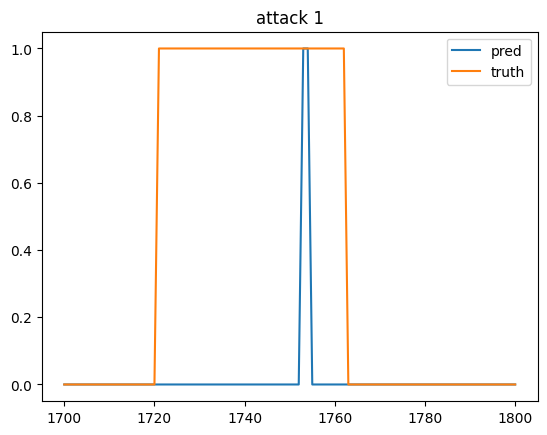

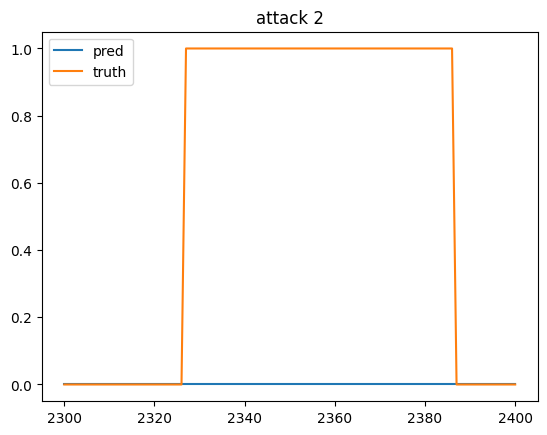

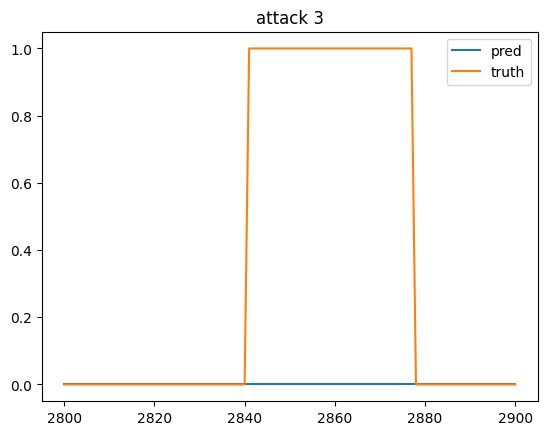

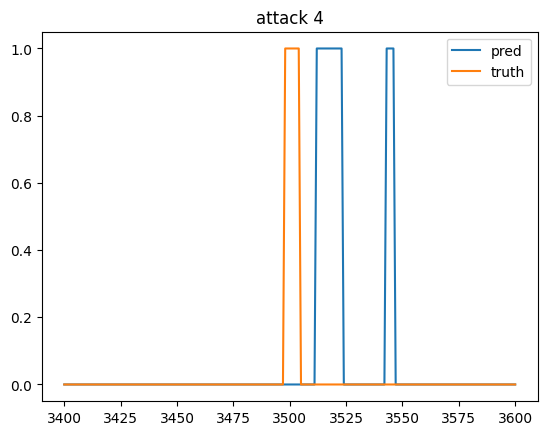

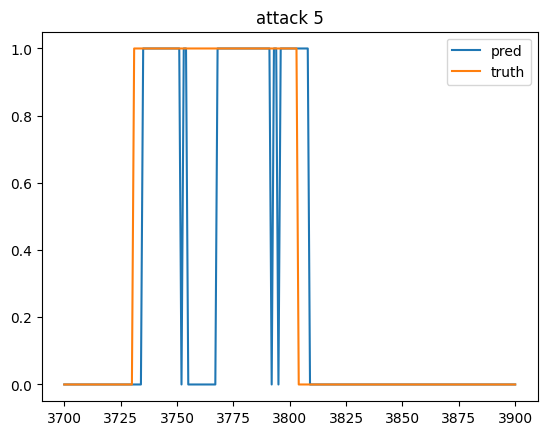

In [123]:

for i,attack in enumerate(attacks):
    left=(attack[0]//100)*100
    right=((attack[1]//100)+1)*100
    labels_df.loc[left:right].plot(title=f"attack {i+1}")

In [ ]:
r=test_result[3].sum(-1)
print(r.max(),r.min(),r.mean())

In [131]:
from evaluate import createMetrics
k=createMetrics(test_result,maximum)
print(k)
k.keys()

{'TP': 55, 'FP': 22, 'TN': 3926, 'FN': 164, 'Accuracy': 0.907660722732544, 'Precision': tensor(0.7143, device='cuda:0'), 'Recall': tensor(0.2511, device='cuda:0'), 'F1': tensor(0.3716, device='cuda:0')}


dict_keys(['TP', 'FP', 'TN', 'FN', 'Accuracy', 'Precision', 'Recall', 'F1'])

In [132]:
k2=['TP', 'FP', 'TN', 'FN']
k1=["Accuracy","Precision","Recall","F1"]
d1={key:[] for key in k1}
d2={key:[] for key in k2}
x=[]
for i in range(100):
    _max=maximum*(.5+i/100)
    rr=createMetrics(test_result,_max)
    x.append(_max)
    for key  in d1.keys():
        d1[key].append(float(rr[key]))
    for key  in d2.keys():
        d2[key].append(float(rr[key]))

<Axes: >

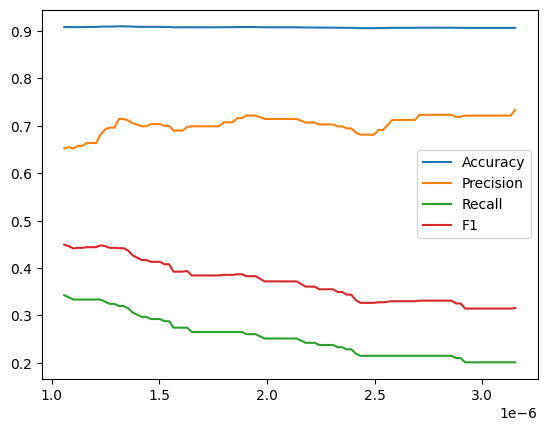

In [133]:
df1=pd.DataFrame(d1,index=x)
df1.plot()

<Axes: >

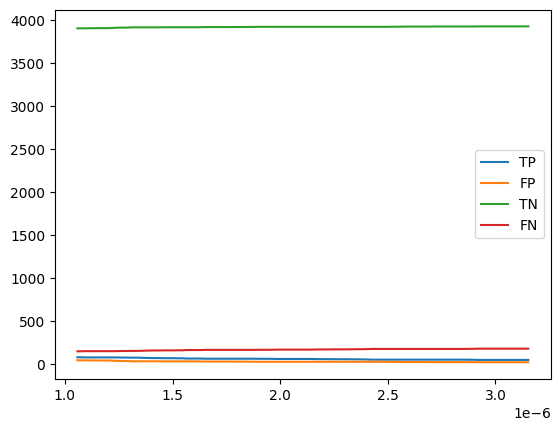

In [134]:
df2=pd.DataFrame(d2,index=x)
df2.plot()

In [ ]:
torch.where(r>10,torch.tensor(1),torch.tensor(0)).sum()

In [ ]:
loss=torch.nn.L1Loss(reduce=False)

In [ ]:
a=torch.arange(0,60).reshape((4,5,3)).float()
b=torch.zeros_like(a).float()


In [ ]:
loss(b,a)

In [ ]:

a.sum(-1)